In [1]:
# Standard library imports.
import os
import requests
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Third party imports.
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
class MELIData:
    def __init__(self) -> None:
        self.meli_url = "https://api.mercadolibre.com/"
        self.dataset_path = "../data/raw"

    def get_sites(self):
        url = f"{self.meli_url}/sites"
        request = requests.get(url)
        sites = request.json()
        return sites

    def get_categories(self, site_id):
        url = f"{self.meli_url}/sites/{site_id}/categories"
        request = requests.get(url)
        categories = request.json()
        return categories

    def search_item_by_category(self, site_id, cat_id, offset=50):
        url = f"{self.meli_url}/sites/{site_id}/search"
        params = {'category': cat_id, 'offset': offset}
        request = requests.get(url, params=params)
        items = request.json()
        return items

    def get_item_features(self, item_id):
        url = f"{self.meli_url}/items/{item_id}"
        request = requests.get(url)
        features = request.json()
        return features

    def convert_and_save_dataframe(self, arr, df_name):
        dataframe = pd.DataFrame(arr)
        dataframe.to_csv(f"{self.dataset_path}/{df_name}.csv", index=False)

    def read_df(self, df_name):
        dataframe = pd.read_csv(f"{self.dataset_path}/{df_name}.csv")
        return dataframe

In [3]:
melidataset = MELIData()

In [4]:
# Get sites - each country has its ID
sites = melidataset.get_sites()
print("sites:", type(sites))
print("sites[0]:", type(sites[0]))

sites: <class 'list'>
sites[0]: <class 'dict'>


In [5]:
melidataset.convert_and_save_dataframe(sites, "sites")

In [6]:
# Get categories - Categories of items belonging to the Marketplace
site_id = 'MCO'
categories = melidataset.get_categories(site_id)
print("categories:", type(categories))
print("categories[0]:", type(categories[0]))

categories: <class 'list'>
categories[0]: <class 'dict'>


In [7]:
melidataset.convert_and_save_dataframe(categories, "categories_MCO")

In [ ]:
# Get items
items = pd.DataFrame()
item_attributes = pd.DataFrame()
item_pictures = pd.DataFrame()

site_id = 'MCO'
df_name = f"categories_{site_id}"
categories = melidataset.read_df(df_name)

# Get the first 1000 items per search
# for each category in the marketplace.
offsets = list(range(0, 1000, 50))

for _, row in tqdm(categories.iterrows(), total=len(categories)):
    # print("key:", type(key))
    category_id = row['id']

    for offset in tqdm(offsets, total=len(offsets)):
        item_cats = melidataset.search_item_by_category(site_id, category_id, offset)
        if 'results' in item_cats:
            resulting_items = item_cats['results']
            if resulting_items is not None:
                for resulting_item in tqdm(resulting_items, total=len(resulting_items)):
                    # The content of 'shipping' is a dictionary.
                    # For this reason it is decided to take the keys and their values
                    # and add them directly to the content of the item
                    shipping_subdict = resulting_item.pop('shipping')
                    if shipping_subdict is not None:
                        resulting_item.update(shipping_subdict)

                    # The content of 'installments' is a dictionary.
                    # For this reason it is decided to take the keys and their values
                    # and add them directly to the content of the item
                    installments_subdict = resulting_item.pop('installments')
                    if installments_subdict is not None:
                        resulting_item.update(installments_subdict)

                    # Add the seller id directly to the item content.
                    resulting_item['seller_id'] = resulting_item['seller']['id']
                    resulting_item.pop('seller')

                    # The item attributes are a list of dictionaries.
                    # It is decided to save them as a separate file
                    attributes = resulting_item['attributes']
                    attributes_ = [{
                        'site_id': site_id,
                        'category_id': category_id,
                        'item_id': resulting_item['id'],
                        **attr,
                    } for attr in attributes]
                    resulting_item.pop('attributes')

                    # The features obtained from the items are not complete.
                    # For this reason, an additional query is made and the relevant keys are stored.
                    features = melidataset.get_item_features(resulting_item['id'])
                    resulting_item['initial_quantity'] = features['initial_quantity']
                    resulting_item['warranty'] = features['warranty']

                    # The 'pictures' are a list of dictionaries.
                    # It is decided to save them as a separate file
                    pictures = features['pictures']
                    pictures_ = [{
                        'site_id': site_id,
                        'category_id': category_id,
                        'item_id': resulting_item['id'],
                        **attr,
                    } for attr in pictures]

                    items_df = pd.DataFrame([resulting_item])
                    item_attributes_df = pd.DataFrame(attributes_)
                    item_pictures_df = pd.DataFrame(pictures_)
                
                    items = pd.concat([items, items_df], ignore_index=True)
                    item_attributes = pd.concat([item_attributes, item_attributes_df], ignore_index=True)
                    item_pictures = pd.concat([item_pictures, item_pictures_df], ignore_index=True)
                os.system('clear')

melidataset.convert_and_save_dataframe(items, "items_MCO")

item_attributes = item_attributes.drop(['values'], axis=1)
melidataset.convert_and_save_dataframe(item_attributes, "item_attributes_MCO")

melidataset.convert_and_save_dataframe(item_pictures, "item_pictures_MCO")

In [9]:
items = melidataset.read_df("items_MCO")
item_attributes = melidataset.read_df("item_attributes_MCO")
item_pictures = melidataset.read_df("item_pictures_MCO")

In [10]:
class EDA:
    """
    This class performs Exploratory Data Analysis (EDA) on the provided dataset.
    """

    def __init__(self, dataframe):
        """
        Initializes the EDA object with the provided dataframe.

        Parameters:
        dataframe (pandas.DataFrame): The dataframe containing the dataset.
        """
        self.dataframe = dataframe

    def show_basic_info(self):
        """
        Display basic information about the dataset such as shape, columns, and data types.
        """
        print("Shape of the dataset:", self.dataframe.shape)
        print("\nColumns in the dataset:")
        print(self.dataframe.columns)
        print("\nData types of columns:")
        print(self.dataframe.dtypes)

    def show_summary_statistics(self):
        """
        Display summary statistics for numerical columns in the dataset.
        """
        print("\nSummary Statistics:")
        print(self.dataframe.describe())

    def show_missing_values(self):
        """
        Display the count of missing values in each column of the dataset.
        """
        print("\nMissing Values:")
        print(self.dataframe.isnull().sum())

    def visualize_data(self):
        """
        Visualize the dataset using suitable plots for analysis.
        """
        # Visualize distribution of numerical features
        numerical_features = self.dataframe.select_dtypes(include=['float64', 'int64'])
        numerical_features.hist(figsize=(12, 10))
        plt.suptitle('Distribution of Numerical Features')
        plt.show()

        # Visualize correlation matrix
        correlation_matrix = numerical_features.corr()
        plt.figure(figsize=(12, 8))
        sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
        plt.title('Correlation Matrix of Numerical Features')
        plt.show()

Shape of the dataset: (31215, 46)

Columns in the dataset:
Index(['id', 'title', 'condition', 'thumbnail_id', 'catalog_product_id',
       'listing_type_id', 'permalink', 'buying_mode', 'site_id', 'category_id',
       'domain_id', 'thumbnail', 'currency_id', 'order_backend', 'price',
       'original_price', 'sale_price', 'available_quantity',
       'official_store_id', 'use_thumbnail_id', 'accepts_mercadopago',
       'stop_time', 'winner_item_id', 'catalog_listing', 'discounts',
       'promotions', 'inventory_id', 'store_pick_up', 'free_shipping',
       'logistic_type', 'mode', 'tags', 'benefits', 'promise', 'quantity',
       'amount', 'rate', 'seller_id', 'initial_quantity', 'warranty',
       'differential_pricing', 'variation_filters', 'variations_data',
       'official_store_name', 'location', 'seller_contact'],
      dtype='object')

Data types of columns:
id                       object
title                    object
condition                object
thumbnail_id          

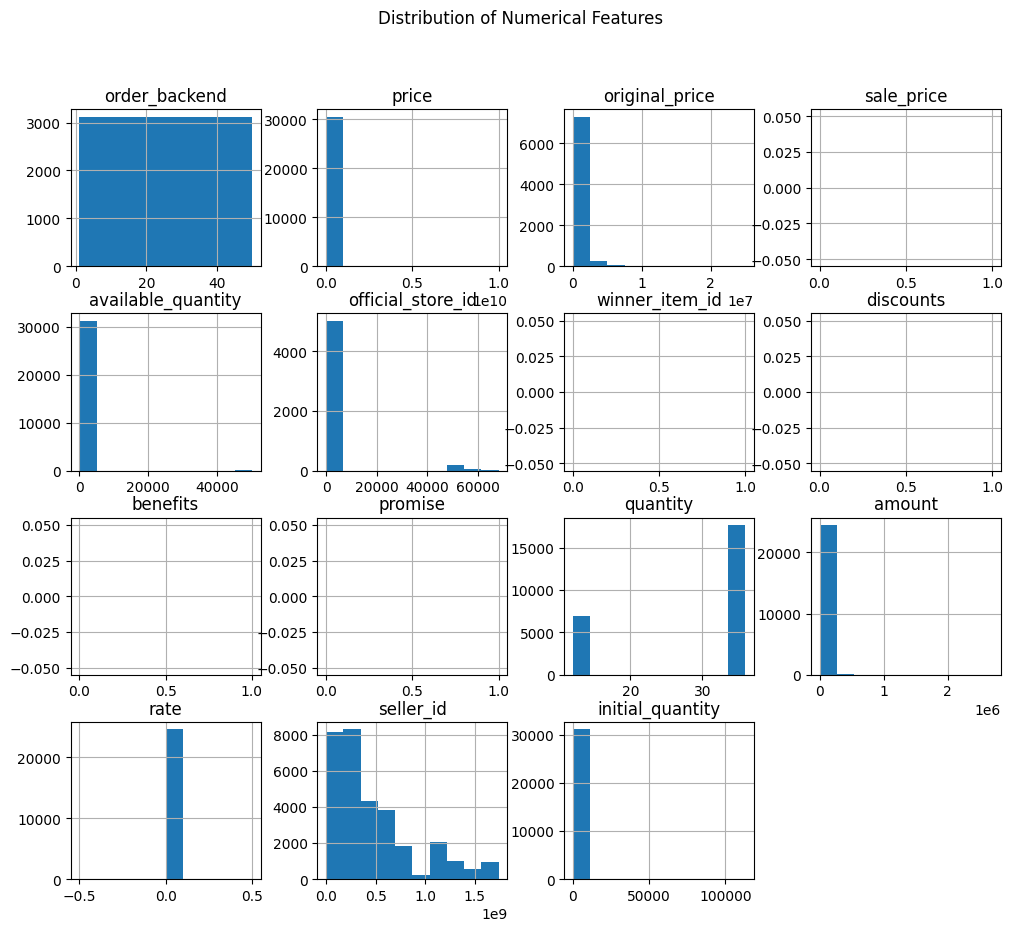

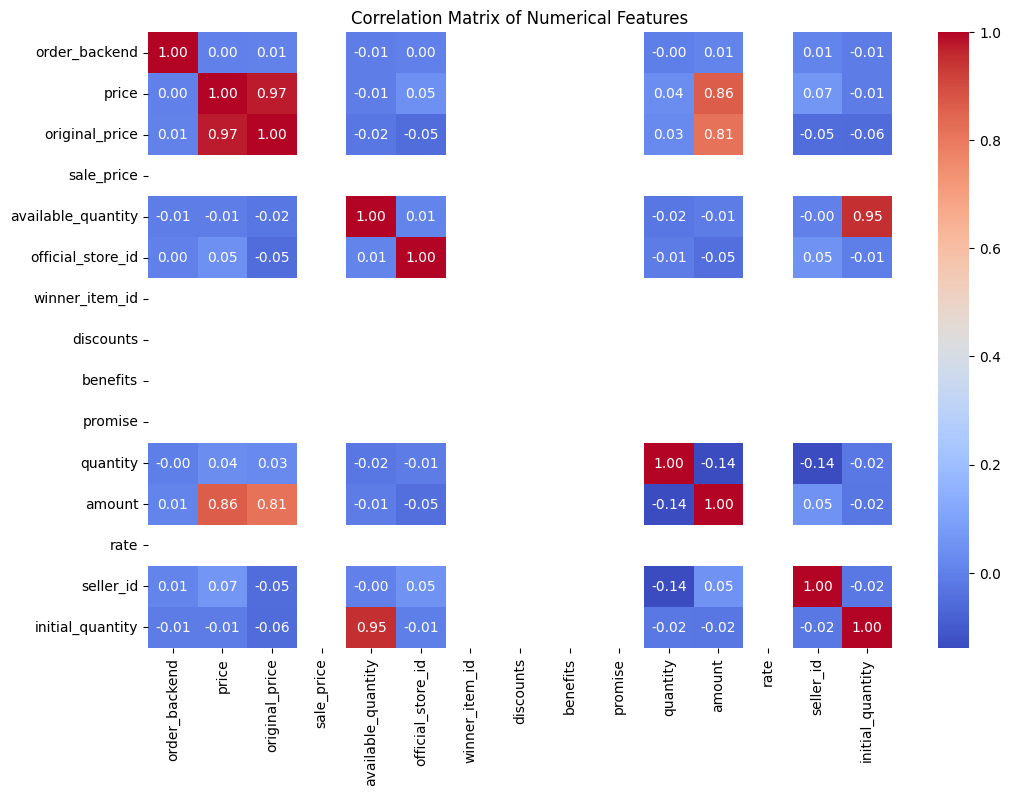

In [11]:
# Instantiate the EDA class with your dataframe
eda = EDA(items)

# Perform EDA steps
eda.show_basic_info()
eda.show_summary_statistics()
eda.show_missing_values()
eda.visualize_data()

Shape of the dataset: (183614, 12)

Columns in the dataset:
Index(['site_id', 'category_id', 'item_id', 'id', 'name', 'value_id',
       'value_name', 'attribute_group_id', 'attribute_group_name',
       'value_struct', 'source', 'value_type'],
      dtype='object')

Data types of columns:
site_id                  object
category_id              object
item_id                  object
id                       object
name                     object
value_id                float64
value_name               object
attribute_group_id       object
attribute_group_name     object
value_struct             object
source                  float64
value_type               object
dtype: object

Summary Statistics:
           value_id        source
count  1.270420e+05  1.835770e+05
mean   6.123731e+06  2.373943e+15
std    2.214581e+08  2.570815e+15
min   -1.000000e+00  1.000000e+00
25%    2.762430e+05  1.000000e+00
50%    2.230284e+06  1.538750e+15
75%    8.665169e+06  4.333790e+15
max    7.889571e+1

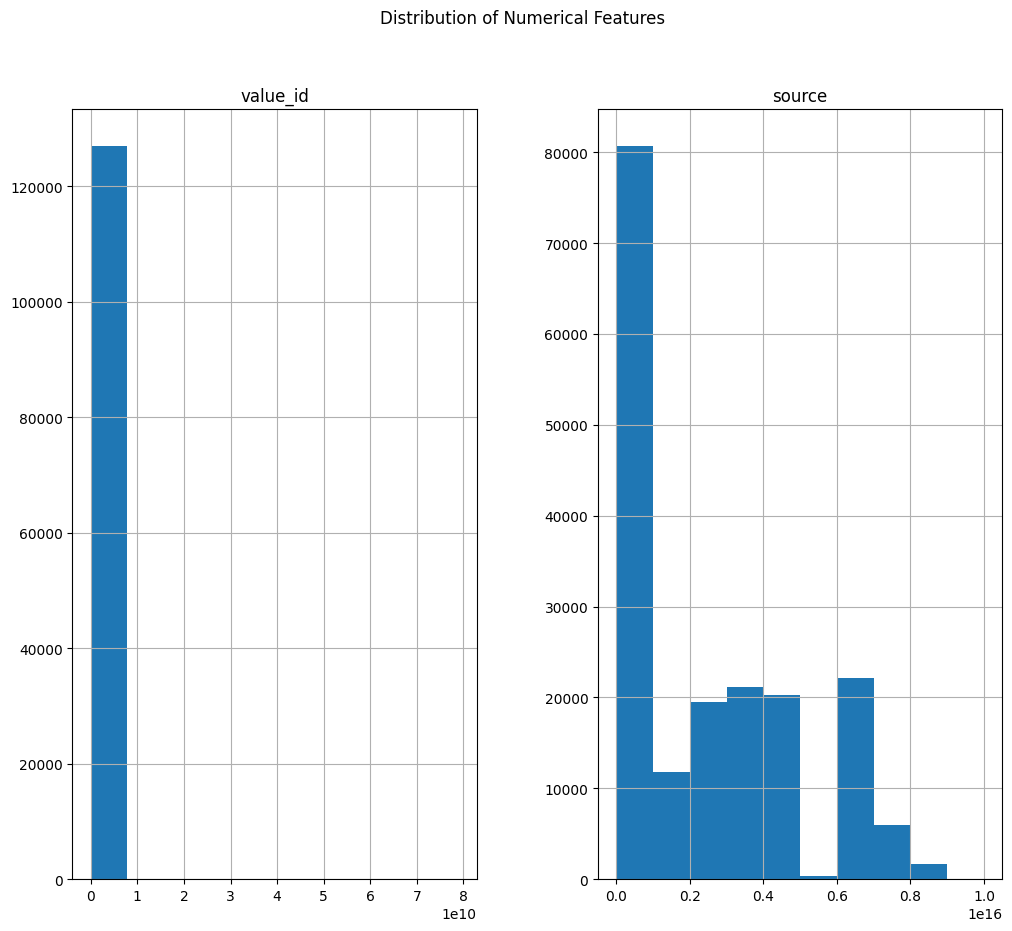

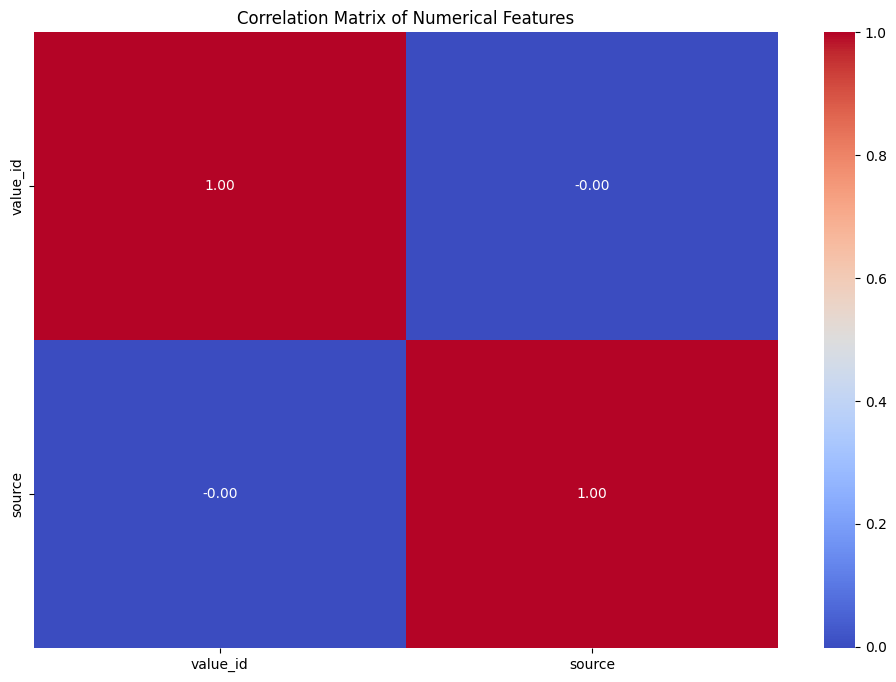

In [12]:
# Instantiate the EDA class with your dataframe
eda = EDA(item_attributes)

# Perform EDA steps
eda.show_basic_info()
eda.show_summary_statistics()
eda.show_missing_values()
eda.visualize_data()

Shape of the dataset: (236229, 9)

Columns in the dataset:
Index(['site_id', 'category_id', 'item_id', 'id', 'url', 'secure_url', 'size',
       'max_size', 'quality'],
      dtype='object')

Data types of columns:
site_id         object
category_id     object
item_id         object
id              object
url             object
secure_url      object
size            object
max_size        object
quality        float64
dtype: object

Summary Statistics:
       quality
count      0.0
mean       NaN
std        NaN
min        NaN
25%        NaN
50%        NaN
75%        NaN
max        NaN

Missing Values:
site_id             0
category_id         0
item_id             0
id                  0
url                 0
secure_url          0
size                0
max_size          233
quality        236229
dtype: int64


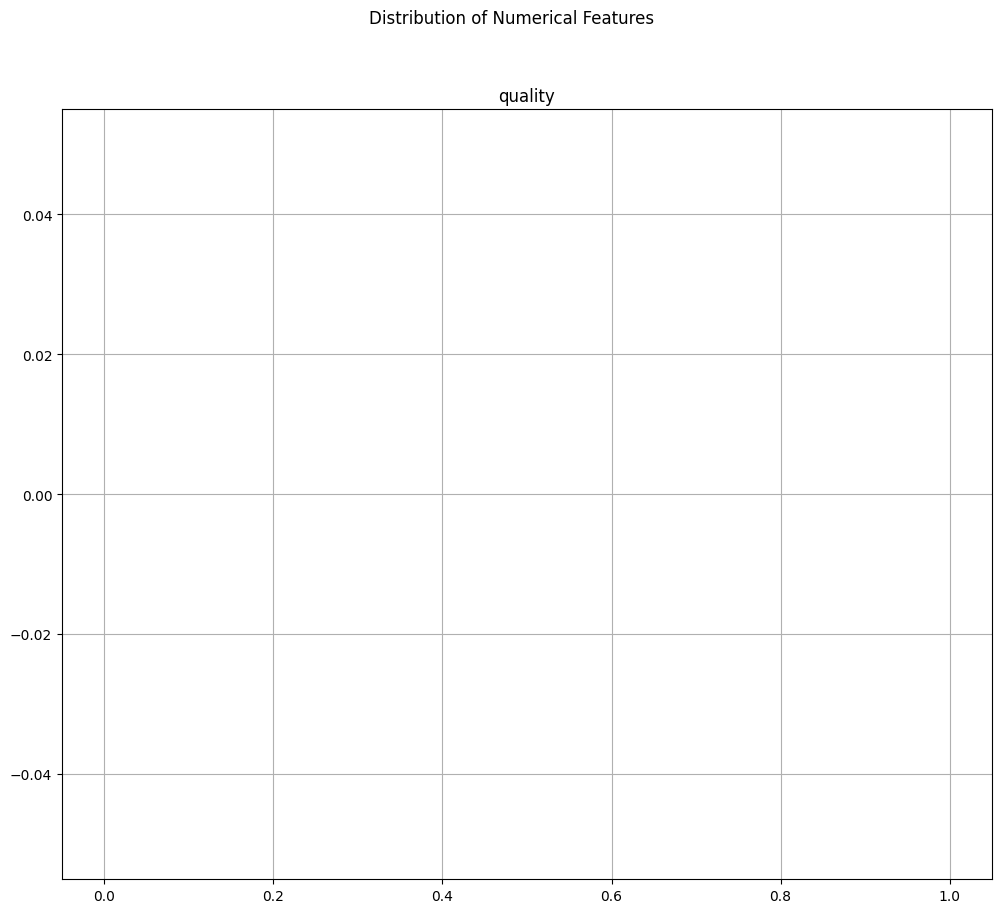

/Users/carolinajimenez/Documents/DEVS/aidevs/mlenv/lib/python3.11/site-packages/seaborn/matrix.py:202: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
/Users/carolinajimenez/Documents/DEVS/aidevs/mlenv/lib/python3.11/site-packages/seaborn/matrix.py:207: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


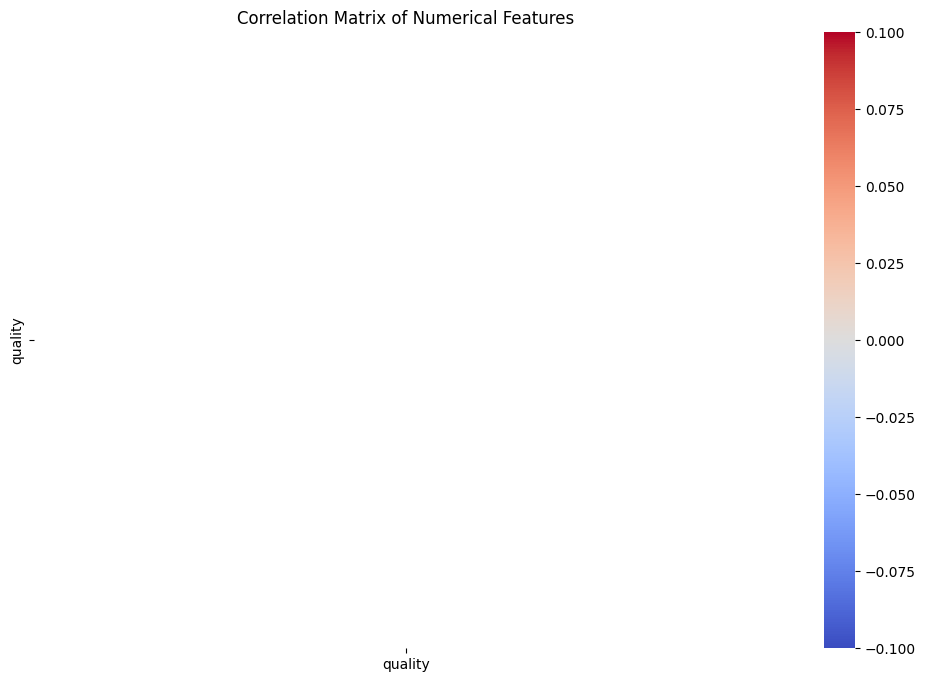

In [13]:
# Instantiate the EDA class with your dataframe
eda = EDA(item_pictures)

# Perform EDA steps
eda.show_basic_info()
eda.show_summary_statistics()
eda.show_missing_values()
eda.visualize_data()

In [13]:
# Encode Categorical Data
condition_dummies = pd.get_dummies(items['condition'], prefix='condition')
items = pd.concat([items, condition_dummies], axis=1)
items.drop('condition', axis=1, inplace=True)

listing_type_id_dummies = pd.get_dummies(items['listing_type_id'], prefix='listing_type_id')
items = pd.concat([items, listing_type_id_dummies], axis=1)
items.drop('listing_type_id', axis=1, inplace=True)

buying_mode_dummies = pd.get_dummies(items['buying_mode'], prefix='buying_mode')
items = pd.concat([items, buying_mode_dummies], axis=1)
items.drop('buying_mode', axis=1, inplace=True)

logistic_type_dummies = pd.get_dummies(items['logistic_type'], prefix='logistic_type')
items = pd.concat([items, logistic_type_dummies], axis=1)
items.drop('logistic_type', axis=1, inplace=True)

# Handle null values
items.fillna('', inplace=True)

# Convert stop_time column to datetime type
items['stop_time'] = pd.to_datetime(items['stop_time'])